# Seizure detection sandbox

## Workspace Preparation

In [1]:
# iEEG imports
from ieeg.auth import Session

# Scientific computing imports
import numpy as np
import scipy as sc
import pandas as pd
import json
from scipy.linalg import hankel
from tqdm import tqdm
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import minmax_scale

# Data IO imports
import mne
import mne_bids
from mne_bids import BIDSPath, read_raw_bids

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Imports for deep learning
import random
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset
import tensorflow as tf
from tensorflow.keras.models import load_model

# OS imports
import os
from os.path import join as ospj
from os.path import exists as ospe
from utils import *
import sys
sys.path.append('/users/wojemann/iEEG_processing')


2024-06-27 12:53:10.190654: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-27 12:53:11.637636: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Memory growth must be set before GPUs have been initialized


2024-06-27 12:53:14.780008: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 12:53:14.798185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 12:53:14.802474: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
plt.rcParams['image.cmap'] = 'magma'

In [4]:
_,_,datapath,prodatapath,figpath,patient_table,rid_hup,_ = load_config(ospj('/mnt/leif/littlab/users/wojemann/stim-seizures/code','config.json'))

In [5]:
temp = pd.read_pickle(ospj(prodatapath,"HUP266","electrode_localizations_dkt.pkl"))
temp.head(-20)

,name,x,y,z,index,label,labels_sorted,percent_assigned
0,R1PO01,117.014,100.65,106.121,2023,right posterior cingulate,"[ right posterior cingulate , left posterior ...","[0.7142857143, 0.1428571429, 0.1428571429]"
1,R1PO02,121.815,98.8313,105.647,0,EmptyLabel,[EmptyLabel],[1.0]
2,R1PO03,126.177,97.6737,104.307,0,EmptyLabel,[EmptyLabel],[1.0]
3,R1PO04,130.548,96.2938,103.94,0,EmptyLabel,[EmptyLabel],[1.0]
4,R1PO05,135.34,94.698,102.493,0,right lateral ventricle,"[EmptyLabel, right lateral ventricle ]","[0.8571428571, 0.1428571429]"
...,...,...,...,...,...,...,...,...
91,RQ04,165.818,112.26,81.704,2015,right middle temporal,"[ right middle temporal , EmptyLabel]","[0.7142857143, 0.2857142857]"
92,RQ05,170.702,113.873,82.0379,2015,right middle temporal,"[ right middle temporal , EmptyLabel]","[0.7142857143, 0.2857142857]"
93,RQ06,175.166,115.702,83.4532,0,right middle temporal,"[EmptyLabel, right middle temporal ]","[0.7142857143, 0.2857142857]"
94,RQ07,179.621,117.753,83.8943,0,EmptyLabel,[EmptyLabel],[1.0]


In [6]:
# temp = pd.read_pickle(ospj(prodatapath,"HUP257","probability_matrix_mdl-LSTM_fs-256_montage-bipolar_task-ictal387681_run-01.pkl"))

In [7]:
set_seed(5210)

In [8]:
pt = 'HUP235'
montage = 'bipolar'
inter_times = {"HUP235": 307651,
               "HUP238": 100011,
               "HUP246": 100000}

In [9]:
all_seizure_times = pd.read_csv(ospj(prodatapath,"consensus_annots.csv"))
seizure_times = all_seizure_times[all_seizure_times.patient == pt]
# seizure_times.head()

## WaveNet

In [10]:
from seizure_detection_pipeline import *

In [11]:
seizures_df = pd.read_csv(ospj(datapath,"stim_seizure_information_BIDS.csv"))

In [12]:
model_path = ospj(prodatapath,'WaveNet','v111.hdf5')
model = load_model(model_path)
# model.summary()
# Should look like outline from Andy's paper
    

2024-06-27 12:53:15.009332: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 12:53:15.013636: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-27 12:53:15.017871: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [13]:
# For each seizure, i need to add the extra step of folding all of the channels into batches

In [14]:
def notch_filter(data: np.ndarray, fs: float) -> np.array:
    """_summary_

    Args:
        data (np.ndarray): _description_
        fs (float): _description_

    Returns:
        np.array: _description_
    """
    # remove 60Hz noise
    b, a = iirnotch(60, 30, fs)
    d, c = iirnotch(120, 30, fs)
    # b, a = butter(8,[55,65],'bandstop',fs=fs)
    # d, c = butter(8,[110,130],'bandstop',fs=fs)

    data_filt = filtfilt(b, a, data, axis=0)
    data_filt_filt = filtfilt(d, c, data_filt, axis = 0)
    # TODO: add option for causal filter
    # TODO: add optional argument for order

    return data_filt_filt

In [15]:
# Loading data from bids
inter,fs = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter = inter[chn_labels]
try:
    electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    electrode_localizations.name = clean_labels(electrode_localizations.name,pt)
    electrode_regions.name = clean_labels(electrode_regions.name,pt)
    electrode_localizations.to_pickle(ospj(prodatapath,pt,'electrode_localizations_atropos.pkl'))
    electrode_regions.to_pickle(ospj(prodatapath,pt,'electrode_localizations_dkt.pkl'))
    neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
except:
    print(f"electrode localization failed for {pt}")
    neural_channels = chn_labels
inter = inter.loc[:,neural_channels]

# Detecting and removing excess noisy channels
# mask,_ = detect_bad_channels(inter.to_numpy(),fs)
# inter = inter.drop(inter.columns[~mask],axis=1)
inter,fs,mask = preprocess_for_detection(inter,fs,wavenet=True)

In [16]:
scaler = RobustScaler()
scaler = scaler.fit(inter)

In [17]:
seizure_times = seizures_df[seizures_df.Patient == pt]
qbar = tqdm(seizure_times.iterrows(),total=len(seizure_times),leave=False)
for i,(_,sz_row) in enumerate(qbar):
    set_seed(1071999)
    if i <= -1:
        continue
    # Load in seizure and metadata for BIDS path
    seizure,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,str(int(sz_row.approximate_onset)),return_path=True, verbose=0)
    # Filter out bad channels from interictal clip
    seizure = seizure[neural_channels]
    seizure = seizure.drop(seizure.columns[~mask],axis=1)
    break


IndexError: boolean index did not match indexed array along dimension 0; dimension is 78 but corresponding boolean dimension is 70

In [ ]:
def plot_fft(signal, sampling_frequency):
    """
    Plots the FFT of a given signal with frequency in Hz on the x-axis.

    Parameters:
    signal (np.array): Input signal
    sampling_frequency (float): Sampling frequency in Hz
    """
    # Number of samples in the signal
    n = len(signal)
    
    # Compute the FFT of the signal
    fft_values = np.fft.fft(signal)
    
    # Compute the corresponding frequencies
    freq = np.fft.fftfreq(n, d=1/sampling_frequency)
    
    # Only use the positive part of the frequencies and FFT values
    positive_freqs = freq[:n//2]
    positive_fft_values = np.abs(fft_values[:n//2])
    
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(positive_freqs, positive_fft_values)
    plt.title('FFT of the Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.show()

In [ ]:
montage = 'bipolar'
fs = 512
target = 128
data = seizure.copy()
chs = data.columns.to_list()
ch_df = check_channel_types(chs)
# Montage
if montage == 'bipolar':
    data_bp_np,bp_ch_df = bipolar_montage(data.to_numpy().T,ch_df)
    bp_ch = bp_ch_df.name.to_numpy()
elif montage == 'car':
    data_bp_np = (data.to_numpy().T - np.mean(data.to_numpy(),1))
    bp_ch = chs
# data_bp_notch = notch_filter(data_bp_np,fs)
b,a = sc.signal.butter(4,[58,62],btype='bandstop',fs=fs)
data_bp_notch = sc.signal.filtfilt(b,a,data_bp_np)
data_bp_filt = bandpass_filter(data_bp_notch,fs,order=8,lo=1,hi=127)
signal_len = int(data_bp_filt.shape[1]/fs*target)
data_bpd = sc.signal.resample(data_bp_filt,signal_len,axis=1).T
fsd = int(target)
data_white = ar_one(data_bpd)
data_white_df = pd.DataFrame(data_white,columns = bp_ch)

(<Figure size 6233.33x40 with 1 Axes>, <Axes: xlabel='Time (s)'>)

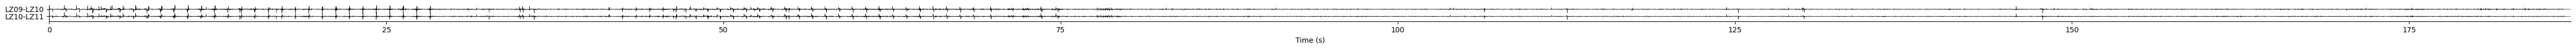

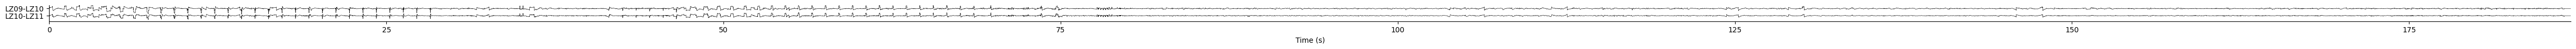

In [ ]:
plot_iEEG_data(pd.DataFrame(data_white,columns=bp_ch).iloc[:,-2:],t=np.linspace(0,len(data_white)/fsd,len(data_white)))
plot_iEEG_data(pd.DataFrame(data_bp_np.T,columns=bp_ch).iloc[:,-2:],t=np.linspace(0,len(data_bp_np.T)/fs,len(data_bp_np.T)))

In [ ]:
plot_fft(data_bp_np[13,:],512)
plot_fft(data_bp_notch[13,:],512)

NameError: name 'plot_fft' is not defined

In [ ]:
power_line_freq = 60

# Function to estimate and remove harmonics for multiple channels without a for loop
def remove_harmonic(signals, freq, fs, order=1):
    # Signal is channels x time
    t = np.arange(signals.shape[1]) / fs
    harmonic_signal = np.sin(2 * np.pi * freq * t)
    harmonic_signal = harmonic_signal[np.newaxis, :]  # Shape to (1, samples)

    # Estimate amplitude and phase
    estimated_amplitude = np.sum(signals * harmonic_signal, axis=1) / signals.shape[1]
    estimated_phase = np.arctan2(
        np.sum(signals * np.cos(2 * np.pi * freq * t), axis=1),
        np.sum(signals * np.sin(2 * np.pi * freq * t), axis=1)
    )
    
    # Broadcast estimated amplitude and phase for each channel
    estimated_harmonic = estimated_amplitude[:, np.newaxis] * np.sin(2 * np.pi * freq * t + estimated_phase[:, np.newaxis])
    
    # Smooth the estimated harmonic
    smoothed_estimate = sc.signal.lfilter([1 - 1/order], [1, -1/order], estimated_harmonic, axis=1)
    
    # Subtract the smoothed estimate from the signals
    return signals - smoothed_estimate

# Estimate and subtract the third harmonic
bipolar_data = remove_harmonic(data_bp_np, 3 * power_line_freq, fs)

# Estimate and subtract the second harmonic
bipolar_data = remove_harmonic(bipolar_data, 2 * power_line_freq, fs)

# Estimate and subtract the fundamental power-line frequency
bipolar_data = remove_harmonic(bipolar_data, power_line_freq, fs)

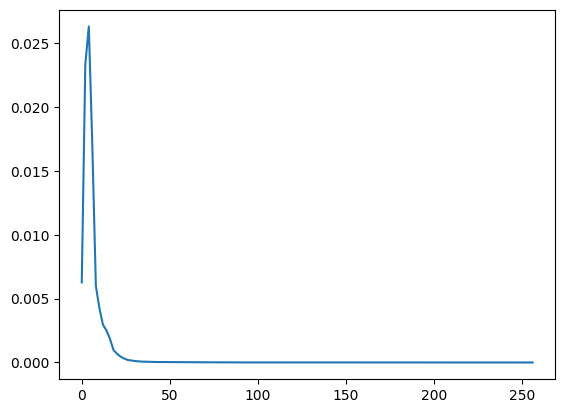

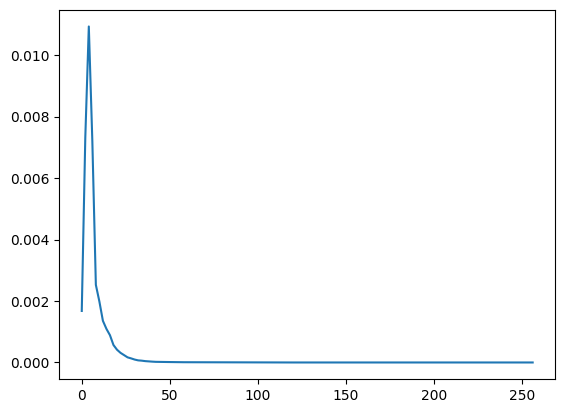

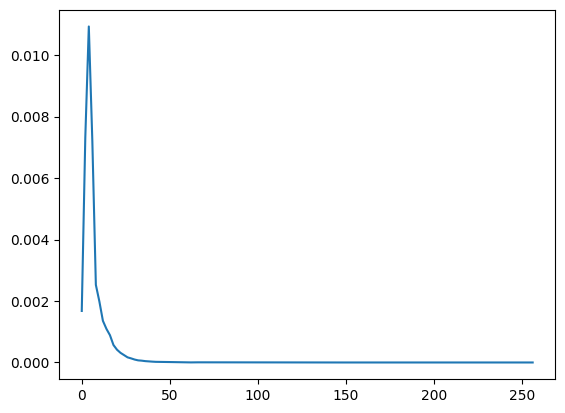

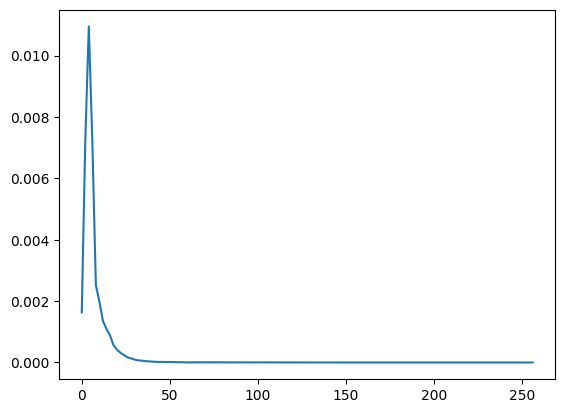

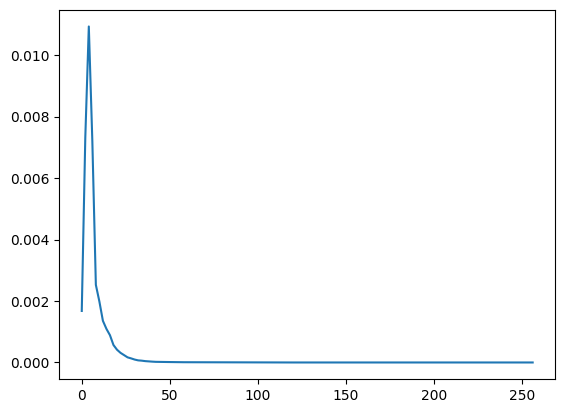

In [ ]:
for sig in [seizure.to_numpy().T,data_bp_np,data_bp_notch,data_bp_filt,bipolar_data]:
    f,pxx = sc.signal.welch(sig[0,:],fs)
    plt.figure()
    plt.plot(f,pxx)

In [ ]:
def prepare_wavenet_segment(data, fs = 128, w_size = 1, w_stride=0.5,ret_time=False):
    data_ch = data.columns.to_list()
    n_ch = len(data_ch)
    data_np = data.to_numpy()
    win_len_idx = w_size*fs
    nwins = num_wins(len(data_np[:,0]),fs,w_size,w_stride)
    data_mat = np.zeros((nwins,win_len_idx,len(data_ch)))
    for k in range(n_ch): # Iterating through channels
        samples = MovingWinClips(data_np[:,k],fs,w_size,w_stride)
        data_mat[:,:,k] = samples
    time_mat = MovingWinClips(np.arange(len(data))/fs,fs,w_size,w_stride)
    win_times = time_mat[:,0]
    data_flat = data_mat.transpose(0,2,1).reshape(-1,win_len_idx)
    if ret_time:
        return data_flat, win_times
    else:
        return data_flat

In [ ]:
seizure,fs = preprocess_for_wavenet(seizure,fs_raw,'bipolar',128)
seizure_z = pd.DataFrame(scaler.transform(seizure),columns=seizure.columns)
print(seizure_z.shape)

NameError: name 'preprocess_for_wavenet' is not defined

In [ ]:
seizure_flat = prepare_wavenet_segment(seizure_z)
seizure_flat.shape

(26040, 128)

In [ ]:
wave_preds = model.predict(seizure_flat)[:,1]

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [ ]:
nwins = num_wins(len(seizure_z),fs,1,0.5)
wave_preds_mat = wave_preds.reshape(nwins,seizure_z.shape[1]).T
wave_preds_mat = sc.ndimage.uniform_filter1d(wave_preds_mat,20,axis=1,mode='constant')
del wave_preds

(<Figure size 6233.07x1400 with 1 Axes>, <Axes: xlabel='Time (s)'>)

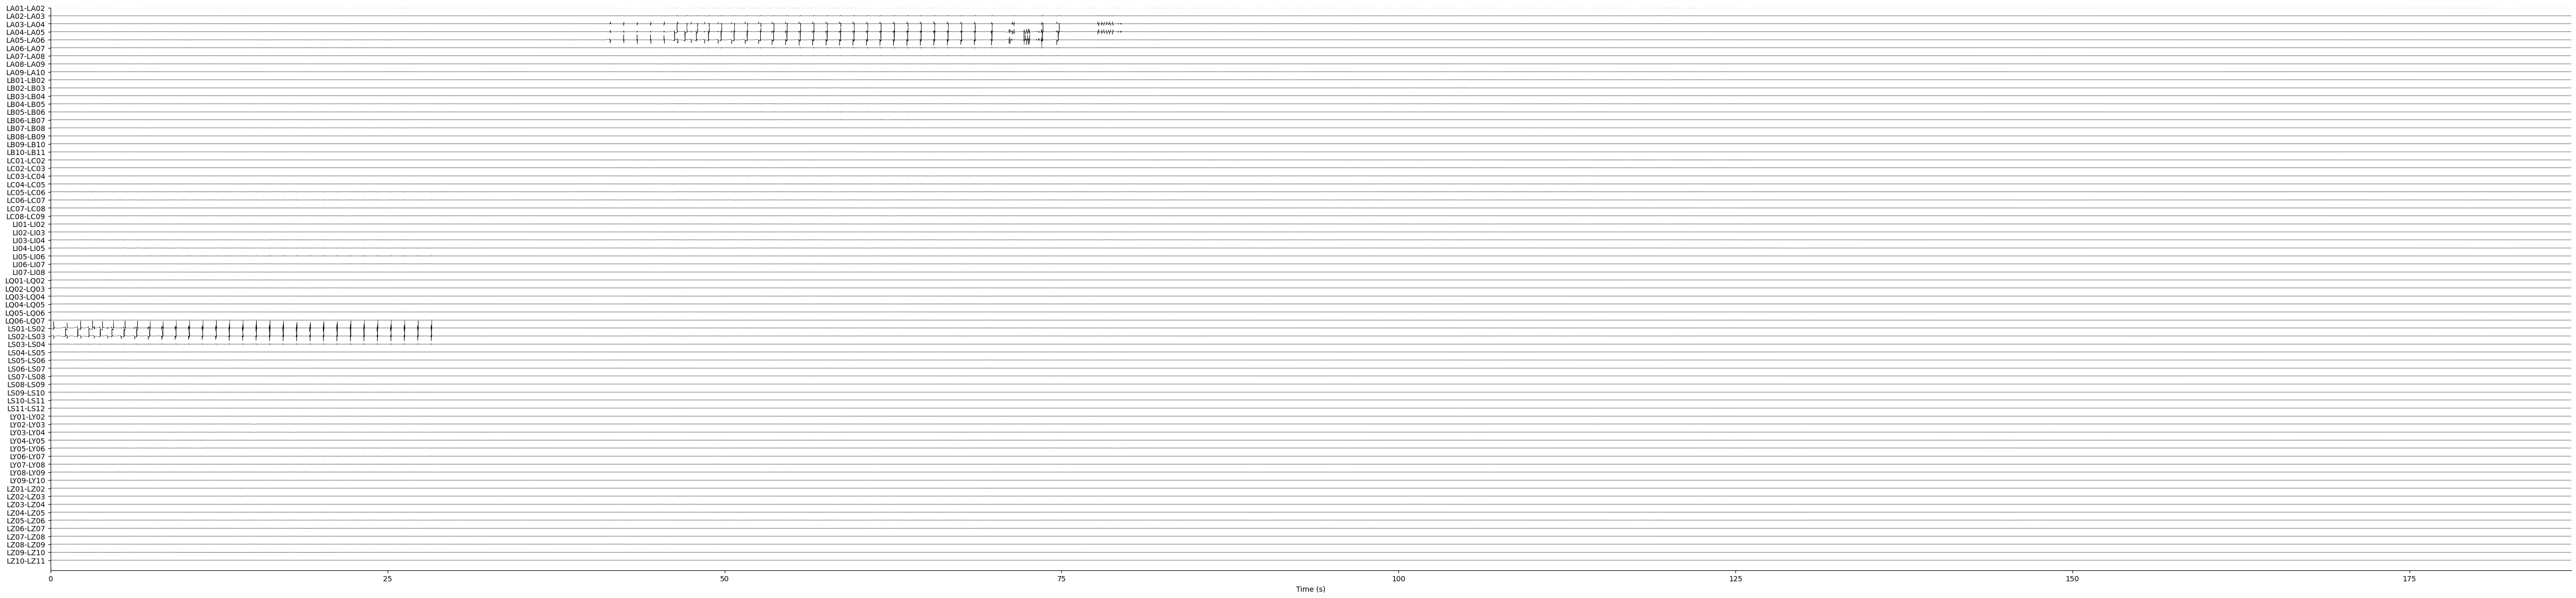

In [ ]:
plot_iEEG_data(seizure_z.loc[:,:],np.linspace(0,len(seizure)/fs,len(seizure)))

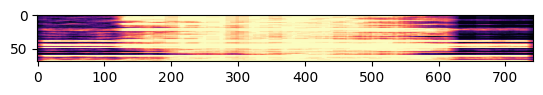

In [ ]:
plt.imshow(wave_preds_mat)

## Interictal networks test

In [ ]:
# Loading data from bids
inter,fs = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
# Pruning channels
chn_labels = remove_scalp_electrodes(inter.columns)
inter = inter[chn_labels]
try:
    electrode_localizations,electrode_regions = electrode_wrapper(pt,rid_hup,datapath)
    electrode_localizations.name = clean_labels(electrode_localizations.name,pt)
    electrode_regions.name = clean_labels(electrode_regions.name,pt)
    electrode_localizations.to_pickle(ospj(prodatapath,pt,'electrode_localizations_atropos.pkl'))
    electrode_regions.to_pickle(ospj(prodatapath,pt,'electrode_localizations_dkt.pkl'))
    neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
except:
    print(f"electrode localization failed for {pt}")
    neural_channels = chn_labels
inter = inter.loc[:,neural_channels]

Index(['LA01-LA02', 'LA02-LA03', 'LA03-LA04', 'LA04-LA05', 'LA05-LA06',
       'LA06-LA07', 'LA07-LA08', 'LA08-LA09', 'LA09-LA10', 'LB01-LB02',
       'LB02-LB03', 'LB03-LB04', 'LB04-LB05', 'LB05-LB06', 'LB06-LB07',
       'LB07-LB08', 'LB08-LB09', 'LB09-LB10', 'LB10-LB11', 'LC01-LC02',
       'LC02-LC03', 'LC03-LC04', 'LC04-LC05', 'LC05-LC06', 'LC06-LC07',
       'LC07-LC08', 'LC08-LC09', 'LI01-LI02', 'LI02-LI03', 'LI03-LI04',
       'LI04-LI05', 'LI05-LI06', 'LI06-LI07', 'LI07-LI08', 'LQ01-LQ02',
       'LQ02-LQ03', 'LQ03-LQ04', 'LQ04-LQ05', 'LQ05-LQ06', 'LQ06-LQ07',
       'LS01-LS02', 'LS02-LS03', 'LS03-LS04', 'LS04-LS05', 'LS05-LS06',
       'LS06-LS07', 'LS07-LS08', 'LS08-LS09', 'LS09-LS10', 'LS10-LS11',
       'LS11-LS12', 'LY01-LY02', 'LY02-LY03', 'LY03-LY04', 'LY04-LY05',
       'LY05-LY06', 'LY06-LY07', 'LY07-LY08', 'LY08-LY09', 'LY09-LY10',
       'LZ01-LZ02', 'LZ02-LZ03', 'LZ03-LZ04', 'LZ04-LZ05', 'LZ05-LZ06',
       'LZ06-LZ07', 'LZ07-LZ08', 'LZ08-LZ09', 'LZ09-LZ10', 'LZ10

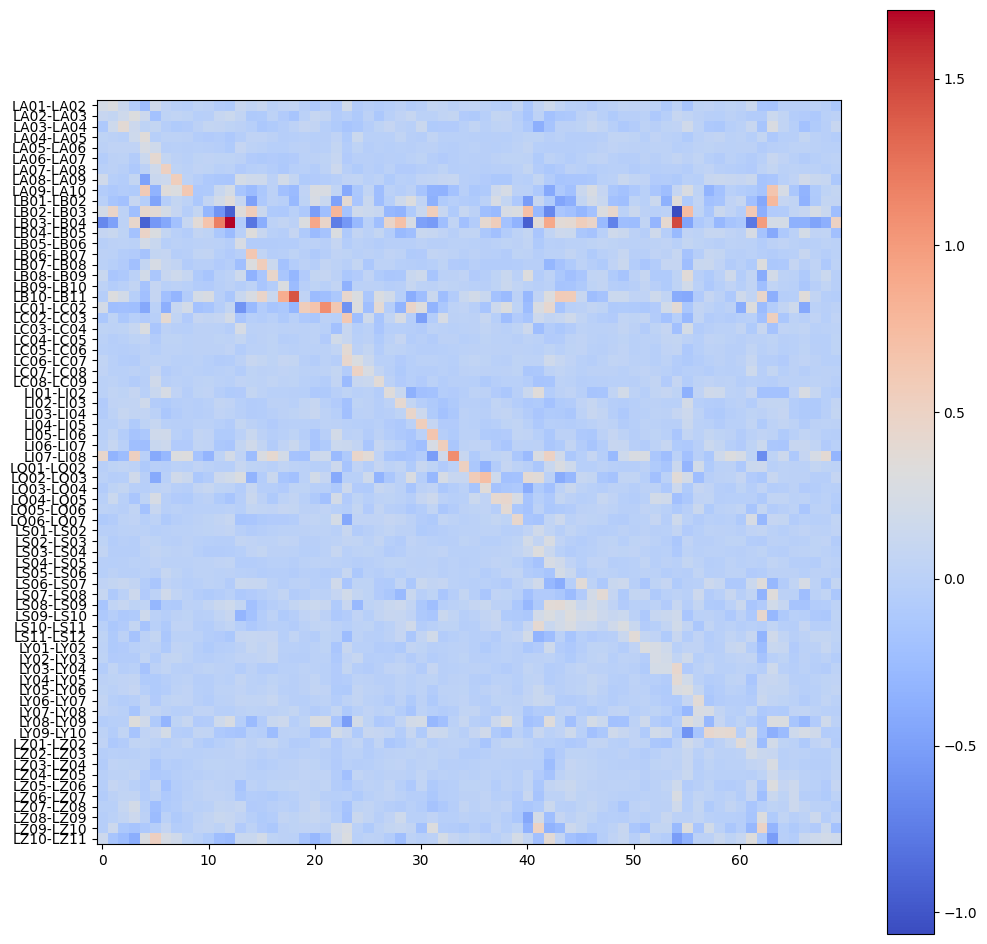

In [ ]:
from sklearn.linear_model import LinearRegression
mdl = LinearRegression()
mdl.fit(inter.iloc[:-1,:],inter.iloc[1:,:])
c = mdl.coef_
plt.figure(figsize=(12,12))
plt.imshow(c,cmap='coolwarm')
plt.colorbar()
plt.yticks(np.arange(inter.shape[1]),inter.columns)
print(inter.columns)

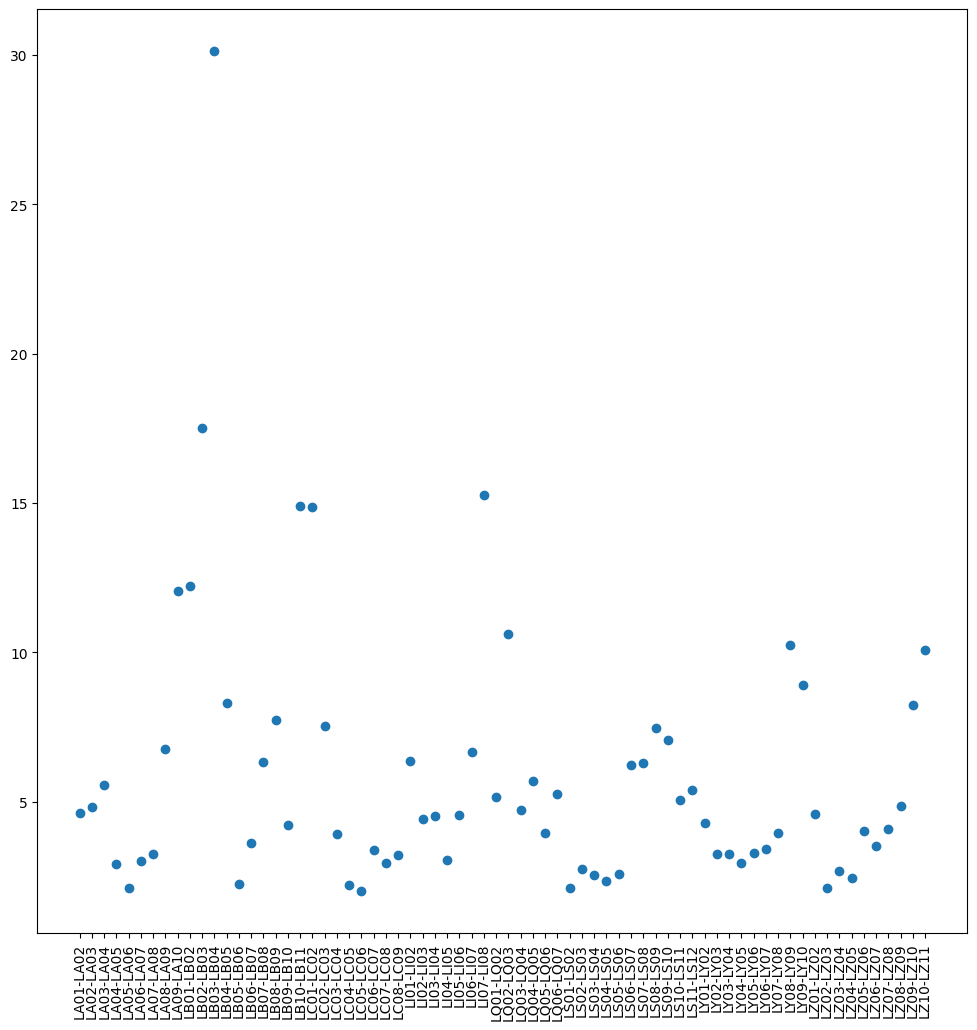

In [46]:
plt.figure(figsize=(12,12))
plt.scatter(np.arange(len(c)),np.sum(np.abs(c),axis=1));
plt.xticks(np.arange(len(c)),inter.columns,rotation=90);

In [64]:
electrode_regions[electrode_localizations.name == 'LB02']
# electrode_localizations.head()

,name,x,y,z,index,label,labels_sorted,percent_assigned
13,LB02,69.4456,126.925,135.293,17,left hippocampus,[ left hippocampus ],[1.0]


## Defining Model Architectures

## Pulling Ictal Data

In [7]:
 # Defining paths for saved data
raw_datapath = ospj(datapath,pt)
if not os.path.exists(ospj(raw_datapath, "seizures")):
    os.mkdir(ospj(raw_datapath, "seizures"))

In [8]:
# access iEEG
with open('woj_ieeglogin.bin', 'r') as f:
  session = Session('wojemann', f.read())
ds = session.open_dataset(f'{pt}_phaseII')
# get labels and time series info
raw_labels = clean_labels(ds.get_channel_labels(),pt)
# chn_labels = [l for l in raw_labels if l not in ['Cz','Fz','C03','C04','F04','F08','Fp02','O01','P04','T04','T06','EKG01','EKG02','ROC','LOC']]
chn_labels = remove_scalp_electrodes(raw_labels)
timeseries = ds.get_time_series_details(chn_labels[0])

#get the sampling frequency
fs = timeseries.sample_rate

IeegConnectionError: 

### Code for saving and preprocessing

In [ ]:
# def preprocess_presave(data,fs,montage='bipolar',factor=4):
#     chs = data.columns.to_list()
#     ch_df = check_channel_types(chs)
#     # Montage
#     if montage == 'bipolar':
#         data_bp_np,bp_ch_df = bipolar_montage(data.to_numpy().T,ch_df)
#         bp_ch = bp_ch_df.name.to_numpy()
#     elif montage == 'car':
#         data_bp_np = (data.to_numpy().T - np.mean(data.to_numpy(),1))
#         bp_ch = chs
#     # Bandpass filtering
#     b,a = sc.signal.butter(4,[3,58],btype='bandpass',fs = fs)
#     data_bp_filt = sc.signal.filtfilt(b,a,data_bp_np,axis=1)
#     # Down sampling
#     data_bpd = sc.signal.decimate(data_bp_filt,factor).T
#     fsd = fs/factor
#     data_white = ar_one(data_bpd)
#     data_white_df = pd.DataFrame(data_white,columns = bp_ch)
#     return data_white_df,fsd

In [ ]:
# for _,row in seizure_times.iterrows():
#     i_sz = int(float(row.Seizure_ID[7:]))
#     print(f"Saving seizure number: {i_sz}")
#     seizure,fs = get_iEEG_data(usr,passpath,
#                                 row.iEEG_ID,
#                                 (row.ueo_time_consensus-60)*1e6,
#                                 (row.offset+60)*1e6,
#                                 chn_labels,
#                                 force_pull = True)
#     seizure_prep,fsd = preprocess_presave(seizure,fs)
#     seizure_prep.to_pickle(ospj(raw_datapath,"seizures",f"det{int(fsd)}_seizure_{i_sz}_stim_{int(row.stim)}_{montage}.pkl"))

## Training Unsupervised Models

### Code for BIDS IO

In [33]:
all_subjects = mne_bids.get_entity_vals(ospj(datapath,'BIDS'),'subject')
ignore_subjects = [s for s in all_subjects if s != 'HUP235']
tasks = mne_bids.get_entity_vals(ospj(datapath,'BIDS'), 'task', ignore_subjects=ignore_subjects)
training_file = [t for t in tasks if 'interictal' in t][0]
ignore_tasks = [t for t in tasks if t != training_file]
run = mne_bids.get_entity_vals(ospj(datapath,'BIDS'), 'run', 
                               ignore_tasks = ignore_tasks,
                               ignore_subjects=ignore_subjects)[0]
training_file


'interictal307651'

In [37]:
bidspath = BIDSPath(root=ospj(datapath,"BIDS"),subject='HUP235',task=training_file,run=run,session='clinical01')

In [38]:
training_raw = read_raw_bids(bidspath)

Extracting EDF parameters from /mnt/leif/littlab/users/wojemann/stim-seizures/RAW_DATA/BIDS/sub-HUP235/ses-clinical01/ieeg/sub-HUP235_ses-clinical01_task-interictal307651_run-00_ieeg.edf...
EDF file detected


Setting channel info structure...
Creating raw.info structure...
Reading events from /mnt/leif/littlab/users/wojemann/stim-seizures/RAW_DATA/BIDS/sub-HUP235/ses-clinical01/ieeg/sub-HUP235_ses-clinical01_task-interictal307651_run-00_events.tsv.
Reading channel info from /mnt/leif/littlab/users/wojemann/stim-seizures/RAW_DATA/BIDS/sub-HUP235/ses-clinical01/ieeg/sub-HUP235_ses-clinical01_task-interictal307651_run-00_channels.tsv.


In [39]:
training_df = training_raw.to_data_frame()
training_df.head()

,time,C03,C04,Cz,EKG01,EKG02,Fz,LA01,LA02,LA03,...,LZ04,LZ05,LZ06,LZ07,LZ08,LZ09,LZ10,LZ11,LZ12,ROC
0,0.000000,52.103308,51.039088,53.962681,176.823631,135.591163,27.112206,-0.259969,-0.123337,-0.069134,...,0.033747,0.042530,0.022053,0.022324,0.020449,0.067769,-0.004543,0.004783,0.022595,0.037472
1,0.001953,48.645596,49.444765,51.569190,173.083832,97.341067,24.453664,-0.261030,-0.124398,-0.067530,...,0.035622,0.045713,0.028443,0.030293,0.026296,0.072037,0.001847,0.009026,0.026049,0.030836
2,0.003906,53.167528,53.962681,58.215546,172.279065,71.257152,29.770749,-0.261572,-0.123337,-0.066469,...,0.037472,0.049438,0.034290,0.034018,0.033476,0.076281,0.013541,0.014355,0.029232,0.038262
3,0.005859,48.910647,48.380545,52.103308,189.557884,95.210801,24.188613,-0.269813,-0.128395,-0.072316,...,0.034537,0.044109,0.030564,0.034018,0.029232,0.074949,0.015663,0.012751,0.027628,0.031354
4,0.007812,46.252105,46.521172,46.786223,179.995360,106.619556,21.530071,-0.275389,-0.135032,-0.077103,...,0.030836,0.041198,0.028689,0.033747,0.027357,0.074677,0.015416,0.009569,0.025235,0.029750


In [43]:
1/training_df.time.diff().mode().item()

512.0

In [45]:
training_df.drop('time',axis=1)

,C03,C04,Cz,EKG01,EKG02,Fz,LA01,LA02,LA03,LA04,...,LZ04,LZ05,LZ06,LZ07,LZ08,LZ09,LZ10,LZ11,LZ12,ROC
0,52.103308,51.039088,53.962681,176.823631,135.591163,27.112206,-0.259969,-0.123337,-0.069134,-0.005851,...,0.033747,0.042530,0.022053,0.022324,0.020449,0.067769,-0.004543,0.004783,0.022595,0.037472
1,48.645596,49.444765,51.569190,173.083832,97.341067,24.453664,-0.261030,-0.124398,-0.067530,-0.005061,...,0.035622,0.045713,0.028443,0.030293,0.026296,0.072037,0.001847,0.009026,0.026049,0.030836
2,53.167528,53.962681,58.215546,172.279065,71.257152,29.770749,-0.261572,-0.123337,-0.066469,-0.004272,...,0.037472,0.049438,0.034290,0.034018,0.033476,0.076281,0.013541,0.014355,0.029232,0.038262
3,48.910647,48.380545,52.103308,189.557884,95.210801,24.188613,-0.269813,-0.128395,-0.072316,-0.012512,...,0.034537,0.044109,0.030564,0.034018,0.029232,0.074949,0.015663,0.012751,0.027628,0.031354
4,46.252105,46.521172,46.786223,179.995360,106.619556,21.530071,-0.275389,-0.135032,-0.077103,-0.019938,...,0.030836,0.041198,0.028689,0.033747,0.027357,0.074677,0.015416,0.009569,0.025235,0.029750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10235,17.277206,19.405646,1.325952,-99.637463,-85.056981,-14.890353,-0.200165,-0.134242,-0.113789,-0.062744,...,-0.003211,0.009569,-0.025268,-0.032718,-0.049717,-0.077103,-0.173322,-0.129974,-0.010909,0.073888
10236,14.883715,18.076375,1.860070,-96.181699,-110.288789,-15.950558,-0.195650,-0.132910,-0.112186,-0.061411,...,-0.001336,0.013541,-0.019938,-0.026871,-0.042538,-0.070466,-0.167475,-0.125459,-0.009848,0.069644
10237,16.482053,19.136579,4.783663,-81.601217,-105.223492,-13.026964,-0.194318,-0.134242,-0.112186,-0.061411,...,0.001575,0.015663,-0.015424,-0.021271,-0.037505,-0.064347,-0.162417,-0.122005,-0.007997,0.069101
10238,20.999969,25.252833,8.771477,-116.158854,-138.455630,-6.914726,-0.192714,-0.131035,-0.109003,-0.061954,...,0.005029,0.019388,-0.010391,-0.013302,-0.031904,-0.057957,-0.157088,-0.117219,-0.006665,0.073370


### Code for saving and preprocessing

In [11]:
# print(f"Saving interictal training data")
# INTERTIME = inter_times[pt]
# pt_ieeg = f'{pt}_phaseII'
# inter,fs = get_iEEG_data(usr,passpath,
#                             row.iEEG_ID,
#                             INTERTIME*1e6,
#                             (INTERTIME+10)*1e6,
#                             chn_labels,
#                             force_pull = True)

# inter_prep,fsd = preprocess_presave(inter,fs)
# inter_prep.to_pickle(ospj(raw_datapath,"seizures",f"det{int(fsd)}_interictal_{montage}.pkl"))

### Code for data formatting and training

#### data formatting

In [12]:
def prepare_segment(data, fs = 256,train_win = 12, pred_win = 1, w_size = 1, w_stride=0.5,ret_time=False):
    data_ch = data.columns.to_list()
    data_np = data.to_numpy()
    train_win = 12
    pred_win = 1
    j = fs-(train_win+pred_win)+1
    nwins = num_wins(len(data),fs,w_size,w_stride)
    data_mat = torch.zeros((nwins,j,(train_win+pred_win),len(data_ch)))
    for k in range(len(data_ch)): # Iterating through channels
        samples = MovingWinClips(data_np[:,k],fs,1,0.5)
        for i in range(samples.shape[0]):
            clip = samples[i,:]
            mat = torch.tensor(hankel(clip[:j],clip[-(train_win+pred_win):]))
            data_mat[i,:,:,k] = mat
    time_mat = MovingWinClips(np.arange(len(data))/fs,fs,1,0.5)
    win_times = time_mat[:,0]
    data_flat = data_mat.reshape((-1,train_win + pred_win,len(data_ch)))
    input_data = data_flat[:,:-1,:].float()
    target_data = data_flat[:,-1,:].float()
    if ret_time:
        return input_data, target_data, win_times
    else:
        return input_data, target_data

In [13]:
def predict_sz(model, input_data, target_data,batch_size=1):
    dataset = TensorDataset(input_data,target_data)
    dataloader = DataLoader(dataset,batch_size=batch_size,shuffle=False)
    ccheck = torch.cuda.is_available()
    if ccheck:
        model.cuda()
    with torch.no_grad():
        model.eval()
        mse_distribution = []
        for inputs, targets in tqdm(dataloader):
            if ccheck:
                inputs = inputs.cuda()
                targets = targets.cuda()
            outputs = model(inputs)
            mse = (outputs-targets)**2
            mse_distribution.append(mse)
    return torch.cat(mse_distribution).cpu().numpy()

In [14]:
def repair_data(outputs,data,fs=256,train_win=12,pred_win=1,w_size=1,w_stride=.5):
    nwins = num_wins(len(data),fs,w_size,w_stride)
    nchannels = data.shape[1]
    repaired = outputs.reshape((nwins,fs-(train_win + pred_win)+1,nchannels))
    return repaired

#### preparing training

In [15]:
fs = 256
inter = pd.read_pickle(ospj(raw_datapath,"seizures",f"det{fs}_interictal_{montage}.pkl"))

In [16]:
# Prepare input and target data for the LSTM
input_data,target_data = prepare_segment(inter)

dataset = TensorDataset(input_data, target_data)
dataloader = DataLoader(dataset, batch_size=100, shuffle=False)

# Instantiate the model
input_size = input_data.shape[2]
hidden_size = 10
output_size = input_data.shape[2]

In [17]:
input_data.shape

torch.Size([4392, 12, 116])

In [89]:
# Define LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1,:])
        return out
    
class LSTMX(nn.Module):
    def __init__(self, num_channels, hidden_size):
        super(LSTMX, self).__init__()
        self.num_channels = num_channels
        self.lstms = nn.ModuleList([nn.LSTM(1, hidden_size, batch_first=True) for _ in range(num_channels)])
        self.fcs = nn.ModuleList([nn.Linear(hidden_size, 1) for _ in range(num_channels)])

    def forward(self, x):
        outputs = []
        for i in range(self.num_channels):
            out, _ = self.lstms[i](x[:, :, i].unsqueeze(-1))  # LSTM input shape: (batch_size, seq_len, 1)
            out = self.fcs[i](out[:, -1, :])  # FC input shape: (batch_size, hidden_size)
            outputs.append(out.unsqueeze(1))  # Add channel dimension back

        # Concatenate outputs along channel dimension
        output = torch.cat(outputs, dim=1).squeeze()  # shape: (batch_size, num_channels, 1)
        return output

    
class LRModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LRModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        # Flatten the input along the 'sequence length' dimension
        x = x.squeeze()
        out = self.linear(x)
        return out


#### model initialization and training

In [97]:
# Initialize the model
# model = LSTMX(input_size, hidden_size)
model = LSTMModel(input_size,hidden_size,output_size)
print(model)
ccheck = torch.cuda.is_available()
if ccheck:
   model.cuda()
# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

LSTMModel(
  (lstm): LSTM(116, 10, batch_first=True)
  (fc): Linear(in_features=10, out_features=116, bias=True)
)


In [98]:
# Training loop
num_epochs = 100
loss_checkpoint = np.inf
brake_check=False
for epoch in range(num_epochs):
    running_loss = 0
    for inputs, targets in dataloader:
        if ccheck:
            inputs = inputs.cuda()
            targets = targets.cuda()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    if epoch % 10 == 9:
        running_loss /= len(dataloader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss:.4f}')
        
        if running_loss < loss_checkpoint:
            loss_checkpoint = running_loss
        else:
            brake_check = True
            break
    if brake_check:
        break

Epoch [10/100], Loss: 59.1389
Epoch [20/100], Loss: 52.8421
Epoch [30/100], Loss: 48.9958
Epoch [40/100], Loss: 47.0130
Epoch [50/100], Loss: 46.2849
Epoch [60/100], Loss: 45.1216
Epoch [70/100], Loss: 44.5073
Epoch [80/100], Loss: 44.3612
Epoch [90/100], Loss: 43.8050
Epoch [100/100], Loss: 43.5915


#### determining detection threshold

In [99]:
input_data,target_data = prepare_segment(inter)
inter_outputs = predict_sz(model,input_data,target_data,batch_size=400)
thresholds = np.percentile(inter_outputs,95,0)

100%|██████████| 11/11 [00:00<00:00, 156.07it/s]


### One class classifier

In [100]:
inter_training_mat = repair_data(inter_outputs,inter)
post_model = svm.OneClassSVM()
model_array = [svm.OneClassSVM() for _ in range(inter_training_mat.shape[2])]
for i,m in enumerate(model_array):
    x_train = np.percentile(inter_training_mat[:,:,i],axis=1,q = 85).reshape(-1,1)
    m.fit(x_train)
    # m.intercept_ *= -1
    # m_cal = CalibratedClassifierCV(m, method='sigmoid')
    # m_cal.fit(x_train, [1] * len(inter_training_mat))
    # m_cal.intercept_ *= -1


## Seizure Detection

### Generating probability heatmaps

In [101]:
def scale_normalized(data,m=5):
    # takes in data and returns a flattened array with outliers removed based on distribution of entire tensor
    data_flat = data.flatten()
    d = np.abs(data_flat - np.median(data_flat))
    mdev = np.median(d)
    s = d / mdev
    scaler = np.max(data_flat[s<m])
    data_norm = data/scaler
    data_norm[data_norm > 1] = 1
    return data_norm

In [102]:
seizure = pd.read_pickle(ospj(raw_datapath,"seizures",f"det{int(256)}_seizure_{2}_stim_{0}_{montage}.pkl"))

In [103]:
mask,info = detect_bad_channels(seizure.to_numpy(),fs)

In [104]:
train_win = 12
pred_win = 1
input_data, target_data, win_times = prepare_segment(seizure,fs,train_win,pred_win,ret_time=True)

In [105]:
outputs = predict_sz(model,input_data,target_data,400)
seizure_mat = repair_data(outputs,seizure)

100%|██████████| 321/321 [00:02<00:00, 134.69it/s]


In [106]:
# Getting raw predicted loss values for each window
raw_sz_vals = np.mean(np.log(seizure_mat),1).T
# Creating classifications
sz_clf = (raw_sz_vals.T > np.log(thresholds)).T
# Dropping channels with too many positive detections (bad channels)
# This should be replaced with actual channel rejection
rejection_mask = np.sum(sz_clf[:,:120],axis=1) > 80#(sz_clf.shape[1]*3/5)
sz_clf[rejection_mask,:] = 0 # fake channel rejection
sz_clf[~mask,:] = 0 # real channel rejection

# Normalizing values of the loss
norm_sz_vals = scale_normalized(np.mean(np.log(seizure_mat),1).T)
# Creating smoothed sz values
sz_vals = sc.ndimage.uniform_filter1d(raw_sz_vals,10,axis=1)
# Creating probabilities by temporally smoothing classification
sz_prob = sc.ndimage.uniform_filter1d(sz_clf.astype(float),10,axis=1)
# Sorting channels based on probability at sz onset
first_detect = np.argmax(sz_prob[:,115:]>.5,axis=1)
first_detect[first_detect == 0] = sz_prob.shape[1]
ch_sorting = np.argsort(first_detect)

# rejecting noisy/late channels
bottom_mask = np.sum(sz_clf[ch_sorting,:],axis=1) > 0
first_zero = np.where(~bottom_mask)[0][0].astype(int)
sz_clf[ch_sorting[first_zero:],:] = 0
sz_prob[ch_sorting[first_zero:],:] = 0
# sz_vals[ch_sorting[first_zero:],:] = 0

### Plotting seizure detection pipeline

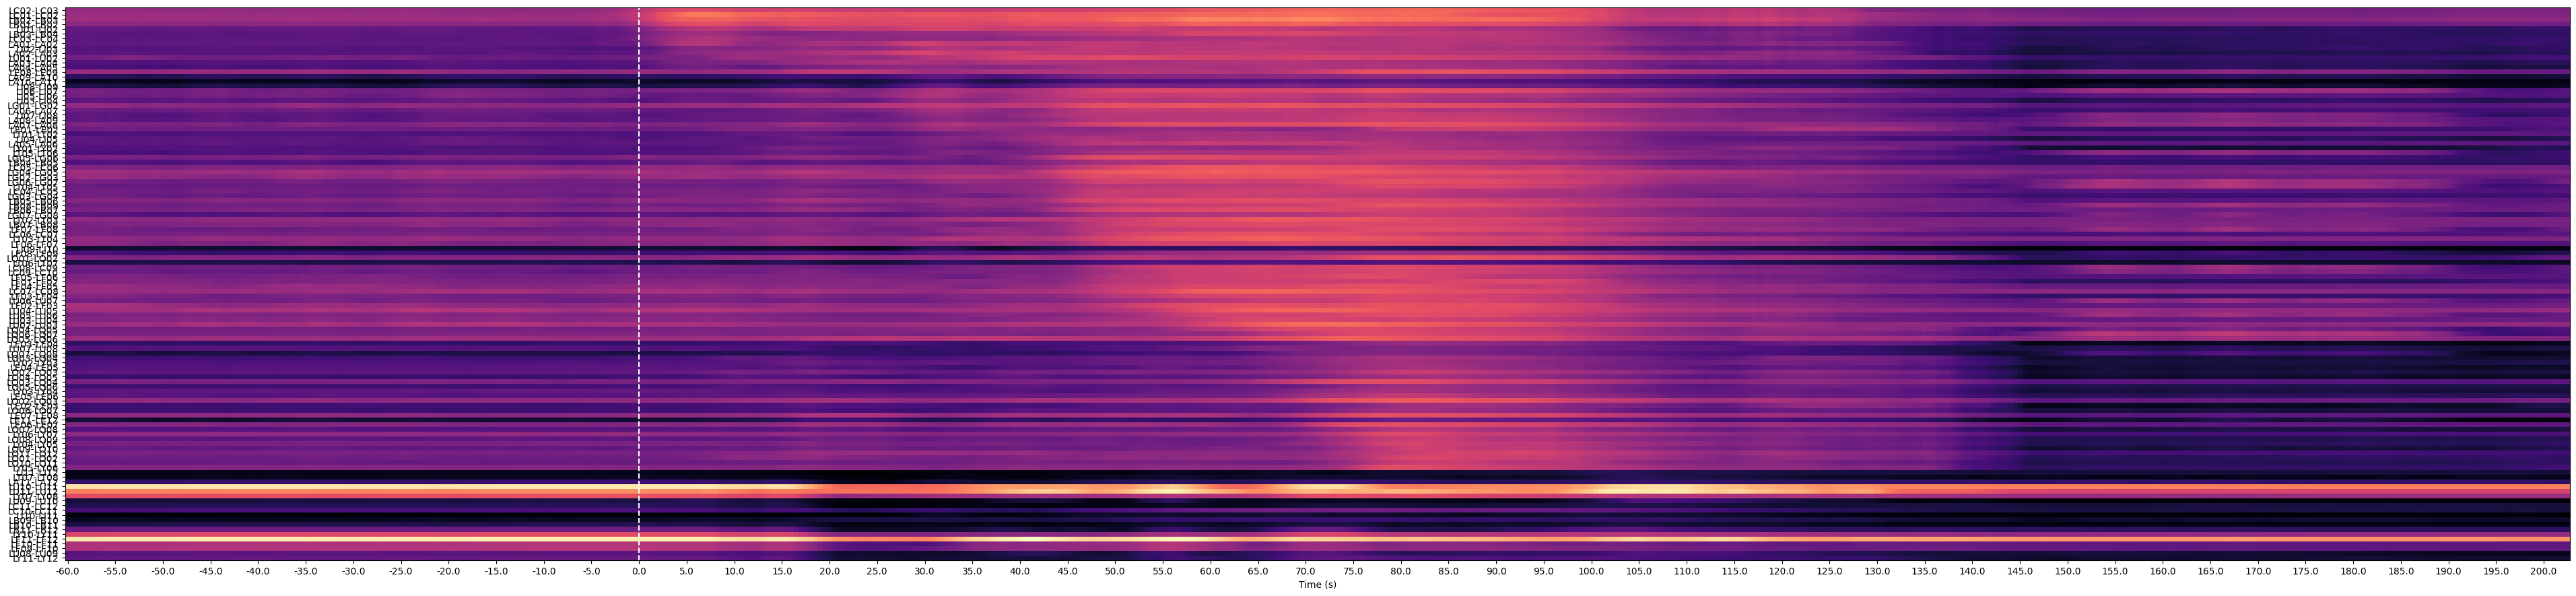

In [107]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_vals[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)] - 60)
# plt.colorbar()
# plt.xlim([115,400])
plt.savefig(ospj(figpath,'sample_vals.png'))

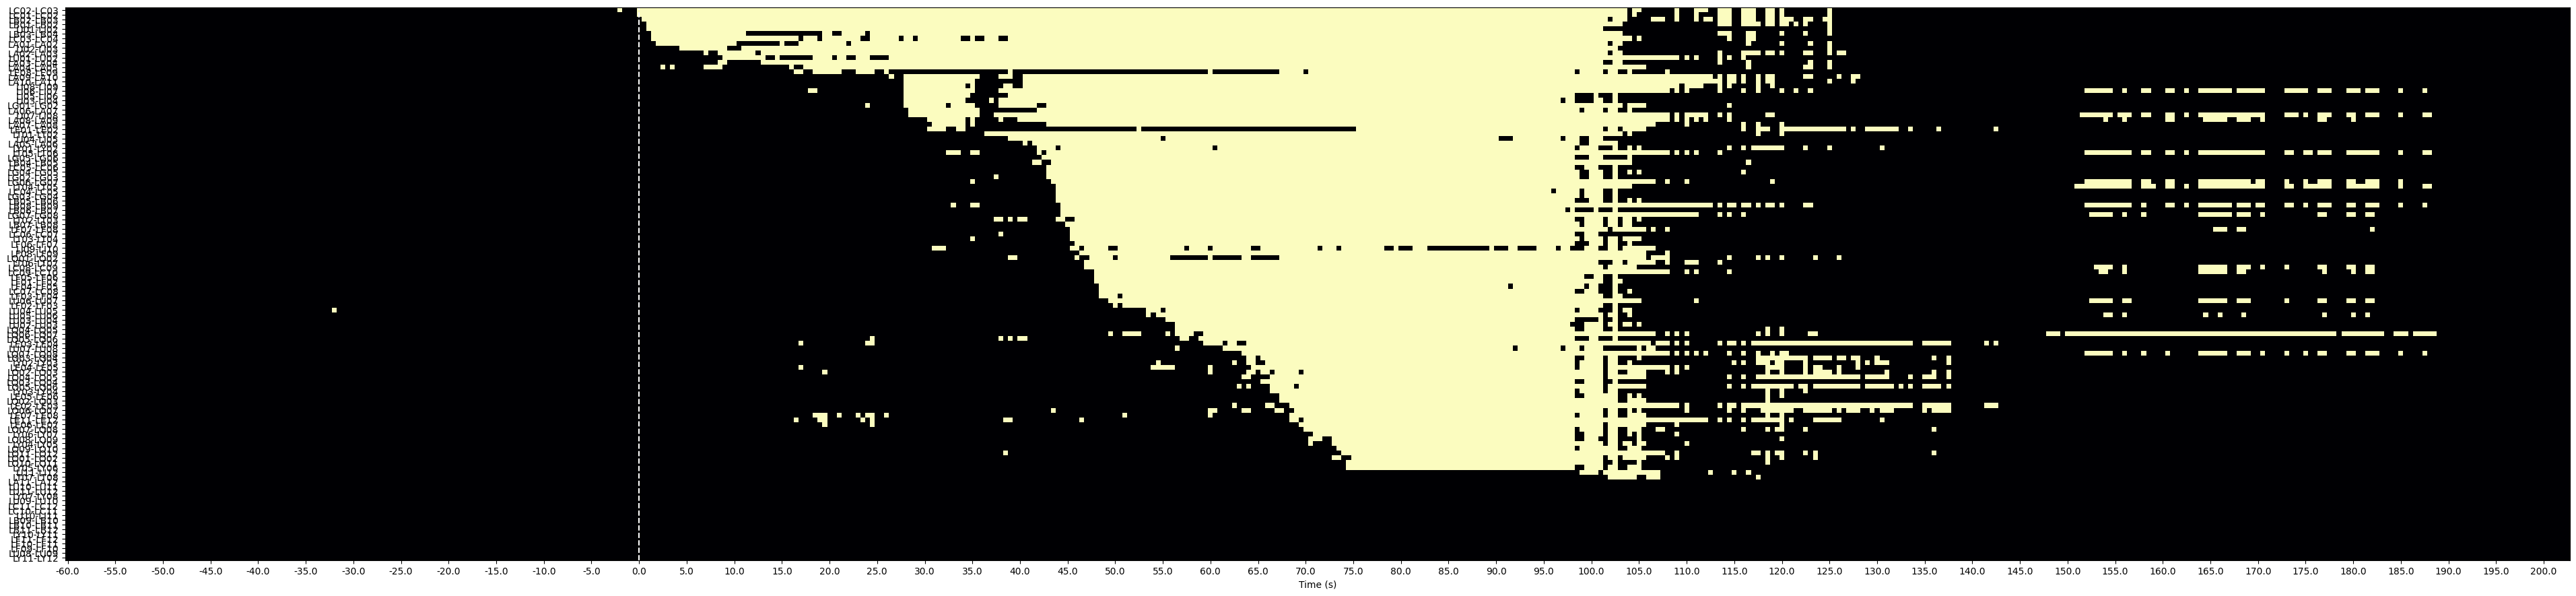

In [108]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_clf[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_vals.png'))

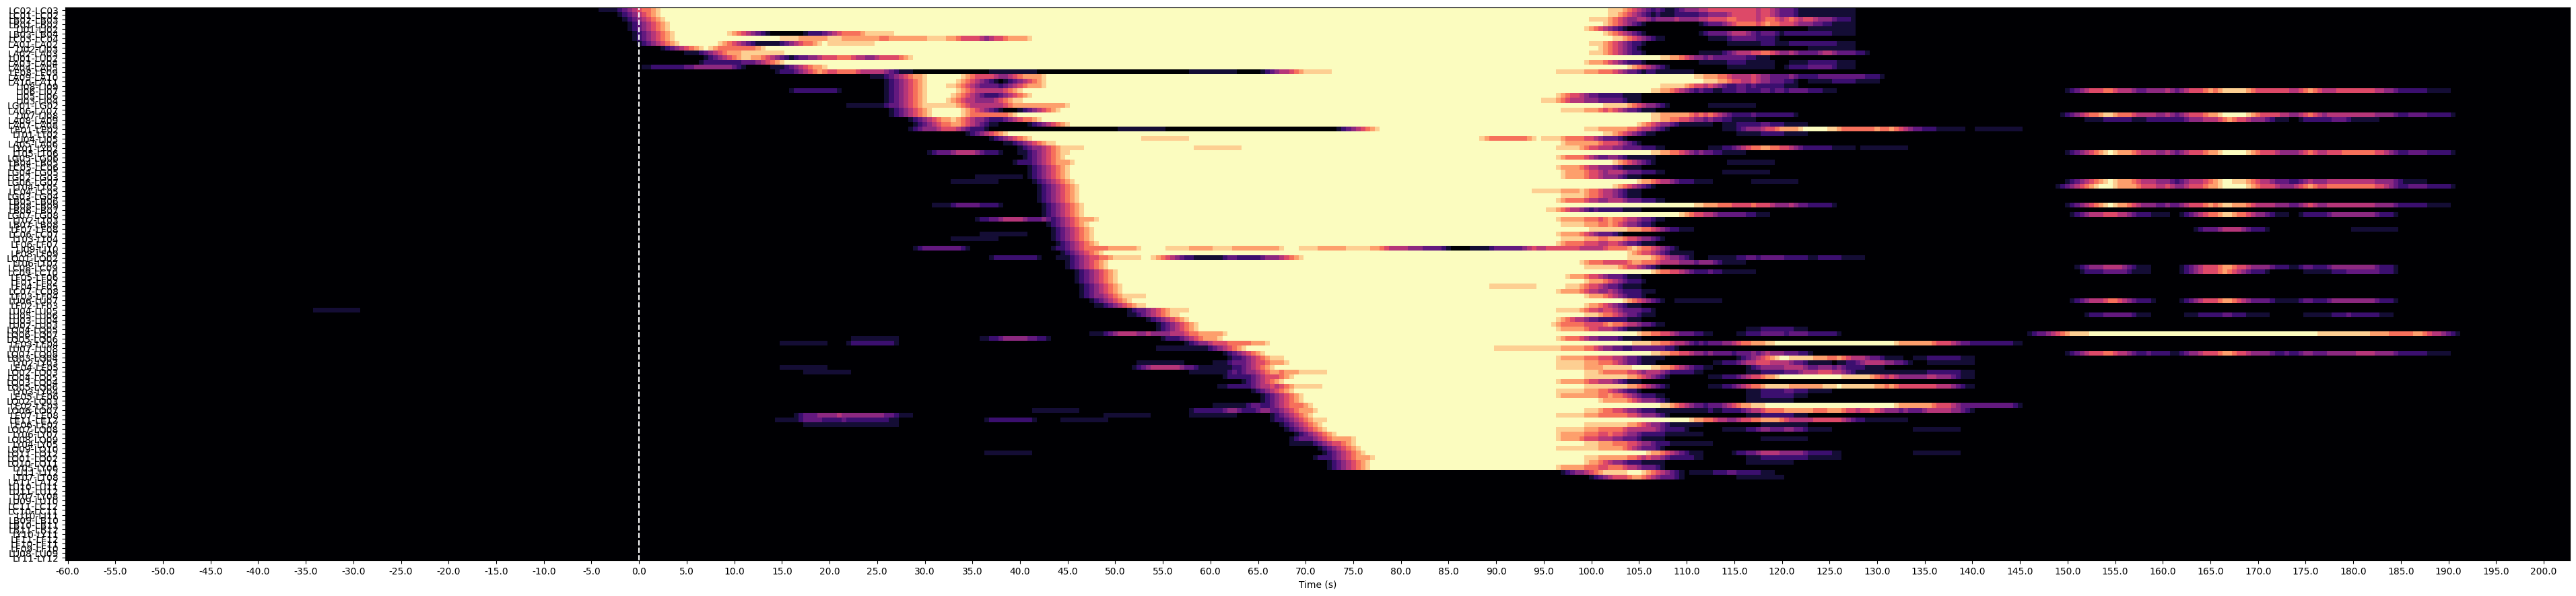

In [109]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_prob[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_prob.png'))

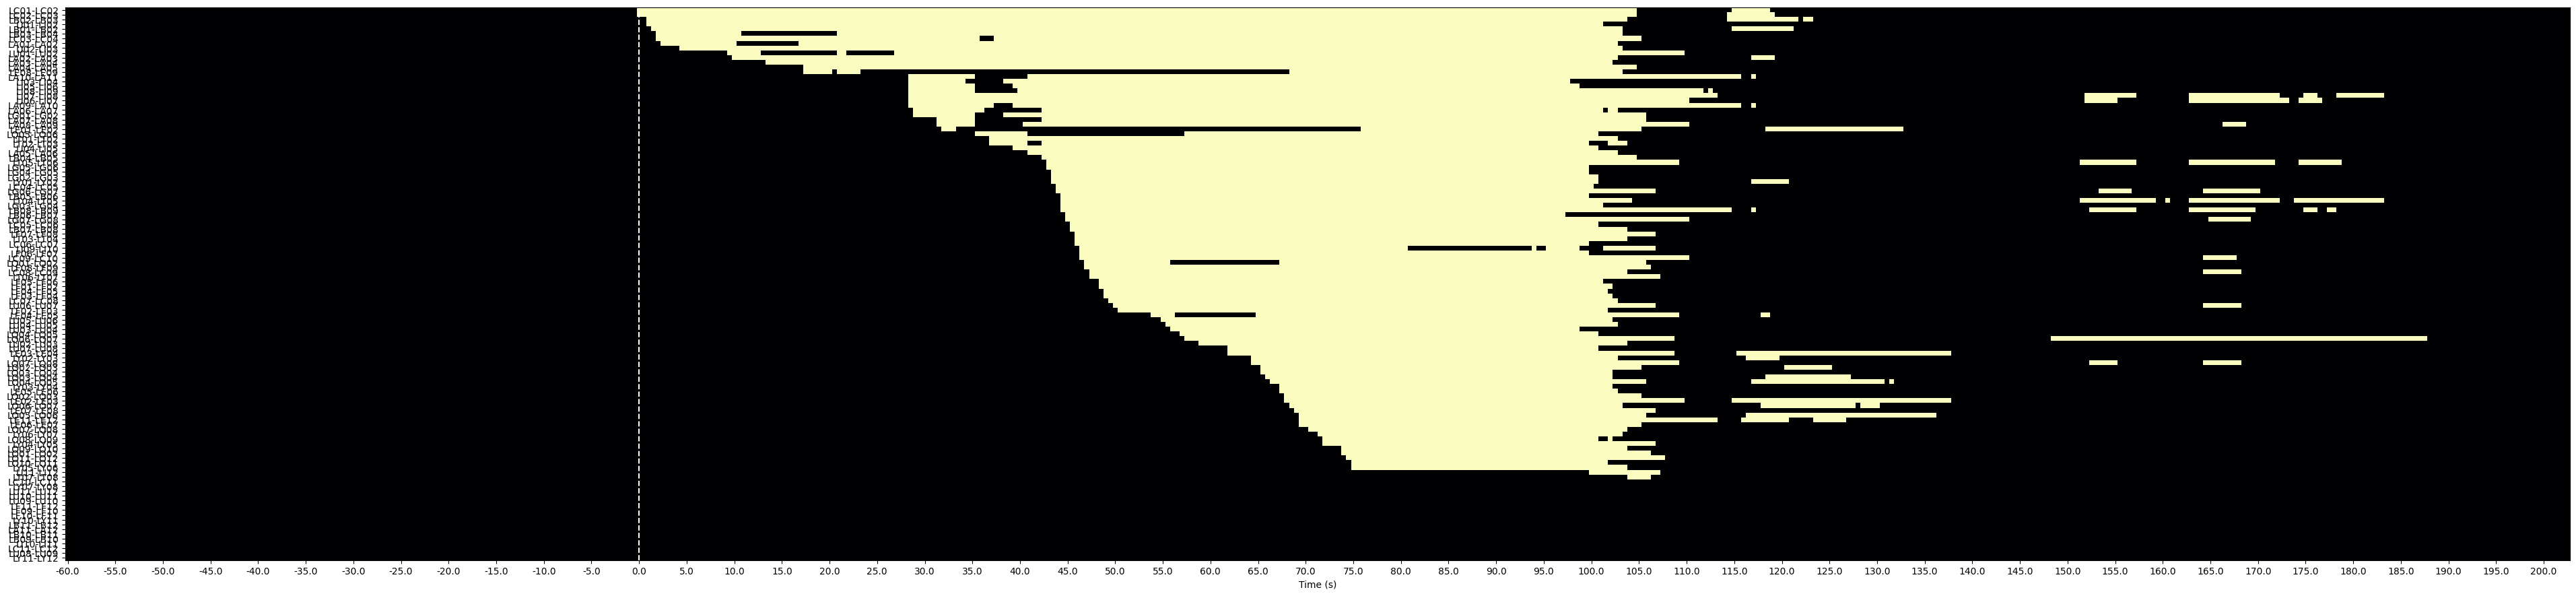

In [43]:
# Example threshold set to 0.6. Will find optimal threshold when we have 
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(sz_prob[ch_sorting,:]>.5)
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.yticks(np.arange(seizure.shape[1]),seizure.columns)
plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_classification.png'))

### Generating UEO predictions

In [44]:
sz_clf_final = sz_prob > 0.5
first_seizing_index = np.argmax(sz_clf_final.any(axis=0))
mdl_ueo_idx = np.where(np.sum(sz_clf_final[:, first_seizing_index:first_seizing_index + 3], axis=1) > 0)[0]
mdl_ueo_ch_bp = seizure.columns.to_numpy()[mdl_ueo_idx]
mdl_ueo_ch = [s.split("-")[0] for s in mdl_ueo_ch_bp]
mdl_ueo_ch

['LB02', 'LC01', 'LC02', 'LI01']

## Univariate Detection

### Dataloading

In [43]:
def optimize_localizations(path_to_recon,RID):
    # /mnt/leif/littlab/data/Human_Data/recon/BIDS_penn/
    # python /mnt/leif/littlab/data/Human_Data/recon/code/run_penn_recons.py
    
    atropos_probs = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-atropos_radius-2_desc-vox_coordinates.json',lines=True)
    dkt_probs = pd.read_json(path_to_recon + f'sub-RID0{RID}_ses-clinical01_space-T00mri_atlas-DKTantspynet_radius-2_desc-vox_coordinates.json',lines=True)
    def _apply_matter_function(x):
        # look in labels sorted and see if it contains gray matter
        # if gray matter is greater than 5% then set label to gray matter
        x = pd.DataFrame(x).transpose()
        for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
            if (label == 'gray matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 2
                break
            elif (label == 'white matter') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                x['index'] = 3
                break
        
        return x
    def _apply_region_function(x):
        # look in labels sorted and see if it contains gray matter
        # if gray matter is greater than 5% then set label to gray matter
        x = pd.DataFrame(x).transpose()
        for i,label in enumerate(x['labels_sorted'].to_numpy()[0]):
            if (label != 'EmptyLabel') and (x['percent_assigned'].to_numpy()[0][i] > 0.05):
                x['label'] = label
                break
        return x
        
    modified_atropos = atropos_probs.iloc[:,:].apply(lambda x: _apply_matter_function(x), axis = 1)
    modified_atropos_df = pd.DataFrame(np.squeeze(np.array(modified_atropos.to_list())),columns=atropos_probs.columns)

    modified_dkt = dkt_probs.iloc[:,:].apply(lambda x: _apply_region_function(x),axis = 1)
    modified_dkt_df = pd.DataFrame(np.squeeze(np.array(modified_dkt.to_list())),columns=dkt_probs.columns)
    modified_dkt_df[modified_atropos_df.label == 'white matter']['label'] = 'white matter'

    return modified_atropos_df,modified_dkt_df

In [44]:
pt = 'HUP238'
hup_no = pt[3:]
rid = rid_hup[rid_hup.hupsubjno == hup_no].record_id.to_numpy()[0]
recon_path = ospj('/mnt','leif','littlab','data',
                    'Human_Data','CNT_iEEG_BIDS',
                    f'sub-RID0{rid}','derivatives','ieeg_recon',
                    'module3/')
if not os.path.exists(recon_path):
    recon_path =  ospj('/mnt','leif','littlab','data',
                    'Human_Data','recon','BIDS_penn',
                    f'sub-RID0{rid}','derivatives','ieeg_recon',
                    'module3/')
electrode_localizations,electrode_regions = optimize_localizations(recon_path,rid)

In [45]:
electrode_regions[electrode_localizations.name.apply(lambda x: x[:2]).isin(['LI'])]

,name,x,y,z,index,label,labels_sorted,percent_assigned
72,LI1,94.4396,135.667,52.0191,1006,left entorhinal,[ left entorhinal ],[1.0]
73,LI2,89.2563,135.71,51.5058,1006,left entorhinal,"[ left entorhinal , EmptyLabel]","[0.696969697, 0.303030303]"
74,LI3,84.0848,135.268,50.839,0,left inferior temporal,"[EmptyLabel, left inferior temporal , left e...","[0.7272727273, 0.1818181818, 0.0909090909]"
75,LI4,78.292,135.596,49.4215,0,left inferior temporal,"[EmptyLabel, left inferior temporal , left m...","[0.696969697, 0.1818181818, 0.12121212120000001]"
76,LI5,73.1206,135.153,48.7547,0,left middle temporal,"[EmptyLabel, left middle temporal ]","[0.5757575758, 0.4242424242]"
77,LI6,68.4455,135.224,48.1979,1015,left middle temporal,"[ left middle temporal , EmptyLabel]","[0.8787878788, 0.12121212120000001]"
78,LI7,63.2622,135.267,47.6846,0,EmptyLabel,[EmptyLabel],[1.0]
79,LI8,58.5871,135.337,47.1278,0,EmptyLabel,[EmptyLabel],[1.0]
80,LI9,53.4157,134.895,46.461,0,EmptyLabel,[EmptyLabel],[1.0]
81,LI10,48.2324,134.938,45.9476,0,EmptyLabel,[EmptyLabel],[1.0]


In [46]:
montage = "bipolar"
inter,fs = get_data_from_bids(ospj(datapath,"BIDS"),pt,'interictal')
chn_labels = np.array(remove_scalp_electrodes(inter.columns))
inter=inter[chn_labels]

# Remove electrodes outside tissue
electrode_localizations.name = clean_labels(electrode_localizations.name,pt)

neural_channels = electrode_localizations.name[(electrode_localizations.name.isin(inter.columns)) & ((electrode_localizations.label == 'white matter') | (electrode_localizations.label == 'gray matter'))]
inter = inter.loc[:,neural_channels]
mask,info = detect_bad_channels(inter.to_numpy(),fs)

bad_channels = set(neural_channels[~mask])
seizure,fs_raw, _, _, task, run = get_data_from_bids(ospj(datapath,"BIDS"),pt,'337800',return_path=True, verbose=0)
seizure = seizure[neural_channels]
sz_mask,info = detect_bad_channels(seizure.to_numpy(),fs)
print(info)
for i in np.where(~sz_mask)[0]:
    bad_channels.add(neural_channels[i])

{'noisy': [], 'nans': [], 'zeros': [], 'flat': [], 'var': [], 'higher_std': array([], dtype=int64), 'high_voltage': []}


In [47]:
seizure = seizure.drop(bad_channels,axis=1)
inter = inter.drop(bad_channels,axis=1)

### Preprocessing

In [48]:
# Preprocess the signals
inter, fs = preprocess_for_detection(inter,fs,montage,factor=2)
seizure, fs = preprocess_for_detection(seizure,fs_raw,montage,factor=2)

In [49]:
scaler = RobustScaler().fit(inter)
ninter = scaler.transform(inter)
nseizure = scaler.transform(seizure)

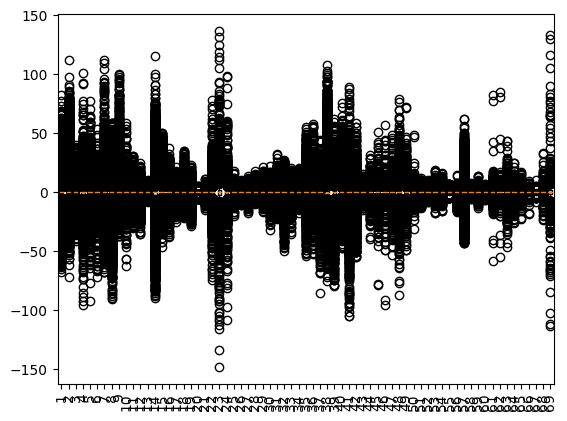

In [50]:
plt.boxplot(nseizure);
ticks,labels = plt.xticks();
plt.xticks(ticks,labels,rotation=90);

### Feature extraction

In [51]:
base_stds = np.std(ninter,axis=0)
abs_slope = lambda x: np.mean(np.abs(np.diff(x,axis=-1)),axis=-1)
all_slopes = ft_extract(nseizure.T,fs,abs_slope,1,.5)
scaled_slopes = all_slopes.squeeze()/np.expand_dims(base_stds,1)*fs
# scaled_slopes = ft_extract(nseizure.T,fs,abs_slope,1,.5)/(0.5*fs)

In [52]:
scaled_slopes = scaled_slopes.squeeze()

In [53]:
def scale_normalized(data,m=5):
    # takes in data and returns a flattened array with outliers removed based on distribution of entire tensor
    data_flat = data.flatten()
    d = np.abs(data_flat - np.median(data_flat))
    mdev = np.median(d)
    s = d / mdev
    scaler = np.max(data_flat[s<m])
    data_norm = data/scaler
    data_norm[data_norm > 1] = 1
    return data_norm

In [54]:
# for i in range(scaled_slopes.shape[0]):
#     scaled_slopes[i,scaled_slopes[i] > 3*np.percentile(scaled_slopes[i],75)] = np.max(scaled_slopes[i])
normalized_slopes = scale_normalized(scaled_slopes.T).T
smoothed_slopes = sc.ndimage.uniform_filter1d(normalized_slopes,10,axis=1)

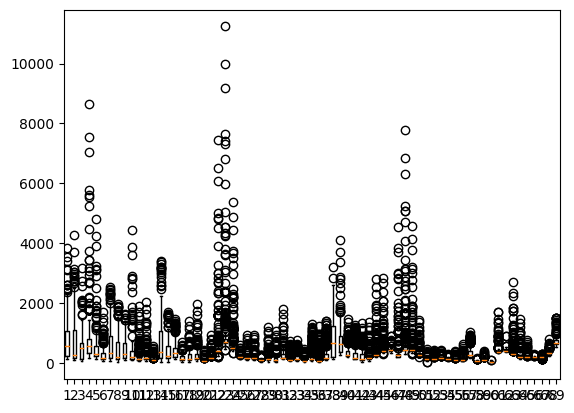

In [55]:
plt.boxplot(scaled_slopes.T);

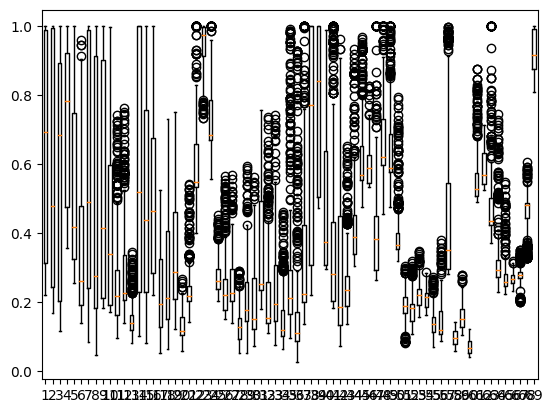

In [56]:
plt.boxplot(smoothed_slopes.T);

In [62]:
class AbsSlope():
    def __init__(self, win_size = 1, stride = .5, fs = 256):
        self.function = lambda x: np.mean(np.abs(np.diff(x,axis=-1)),axis=-1)
        self.win_size = win_size
        self.stride = stride
        self.fs = fs
    
    def __str__(self) -> str:
        return "AbsSlp"
        
    def fit(self, x):
        self.scaler = RobustScaler().fit(x)
        nx = self.scaler.transform(x)
        self.nstds = np.std(nx,axis=0)

    def forward(self, x):
        x = self.scaler.transform(x)
        x = x.T
        slopes = ft_extract(x, self.fs, self.function, self.win_size, self.stride)
        scaled_slopes = slopes.squeeze()/np.expand_dims(self.nstds,1)*self.fs
        scaled_slopes = scaled_slopes.squeeze()
        normalized_slopes = scale_normalized(scaled_slopes)
        return normalized_slopes
    
    def __call__(self, *args):
        return self.forward(*args)

In [69]:
model = AbsSlope(1,.5, 256)
model.fit(inter)
y = model(seizure)
sum(sum(~(normalized_slopes == y)))

0

In [59]:
first_detect = np.argmax(smoothed_slopes[:,110:]>.8,axis=1)
first_detect[first_detect == 0] = smoothed_slopes.shape[1]
ch_sorting = np.argsort(first_detect)

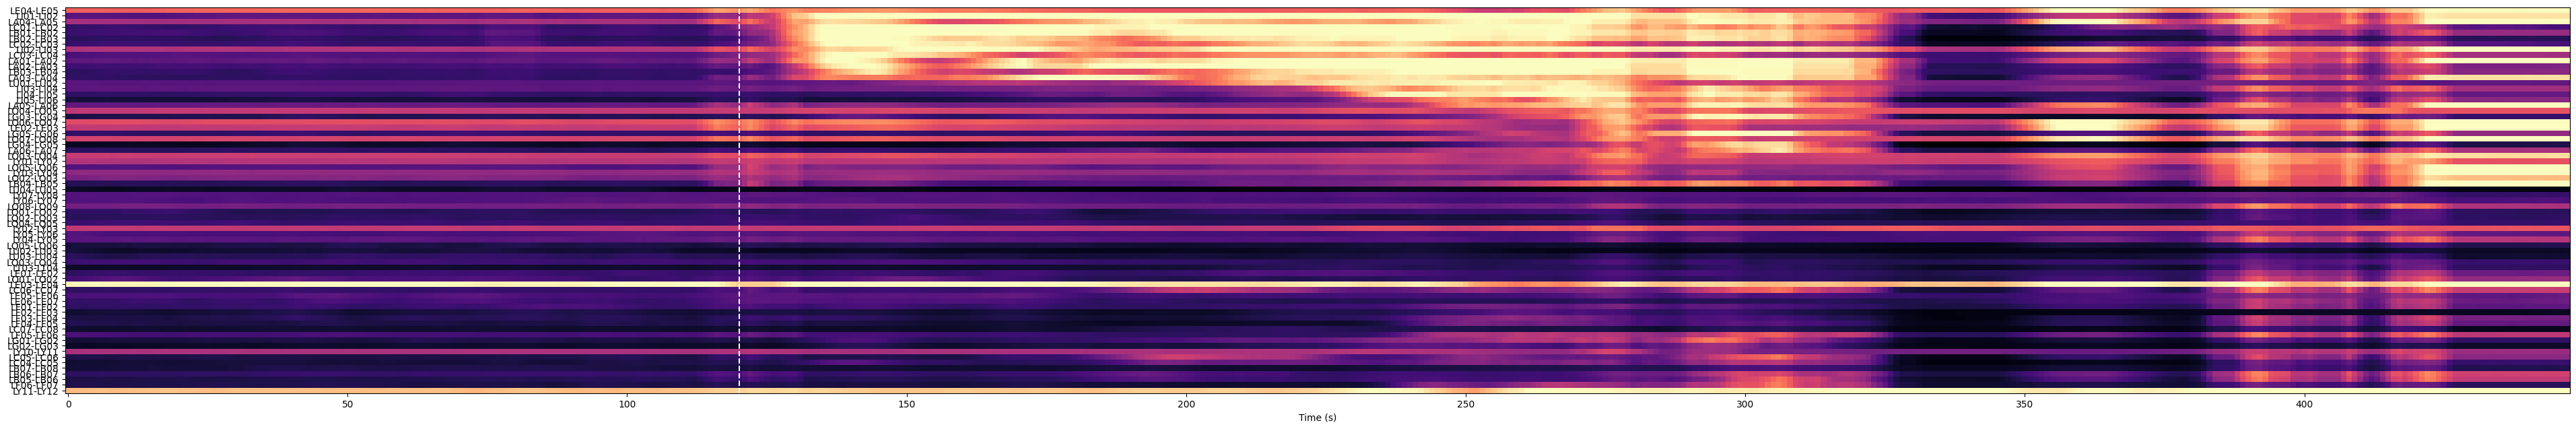

In [38]:
fig,ax = plt.subplots(figsize=(48,24))
plt.imshow(smoothed_slopes[ch_sorting,:])
plt.axvline(120,linestyle = '--',color = 'white')
plt.xlabel('Time (s)')
plt.yticks(np.arange(seizure.shape[1]),seizure.columns[ch_sorting],rotation=0,fontsize=10)
# plt.xticks(np.arange(0,len(win_times),10),win_times.round(1)[np.arange(0,len(win_times),10)]-60)
# plt.colorbar()
# plt.xlim((115,400))
plt.savefig(ospj(figpath,'sample_null.png'))